In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import time

In [287]:
dataset = 'pageRank'
label = 'executorRunTime'
df = pd.read_csv(f'modelData-new/{dataset}Data.csv')
labelcol = df[label]
df.drop(columns=['numStages', 'executorCpuTime', 'executorRunTime', 'peakExecutionMemory', 'elapsedTime'], inplace=True)
dfcopy = pd.DataFrame(labelcol, columns=[label])
dfcopy = dfcopy.merge(df, left_index=True, right_index=True) 
df = dfcopy
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   executorRunTime  372 non-null    int64  
 1   numNodes         372 non-null    int64  
 2   numEdges         372 non-null    int64  
 3   datasetSize      372 non-null    float64
 4   graphType        372 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 14.7+ KB


In [288]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
executorRunTime,372.0,2.786920e+05,4.781728e+05,2.679200e+04,7.184550e+04,1.311770e+05,2.424022e+05,3.235217e+06
numNodes,372.0,1.178222e+04,3.953750e+03,5.059000e+03,9.143250e+03,1.143400e+04,1.397725e+04,2.195800e+04
numEdges,372.0,3.013755e+07,2.378391e+07,3.391803e+06,1.393371e+07,2.214337e+07,3.534657e+07,1.210285e+08
datasetSize,372.0,2.934751e+02,2.351529e+02,3.135115e+01,1.329116e+02,2.189850e+02,3.631187e+02,1.213665e+03


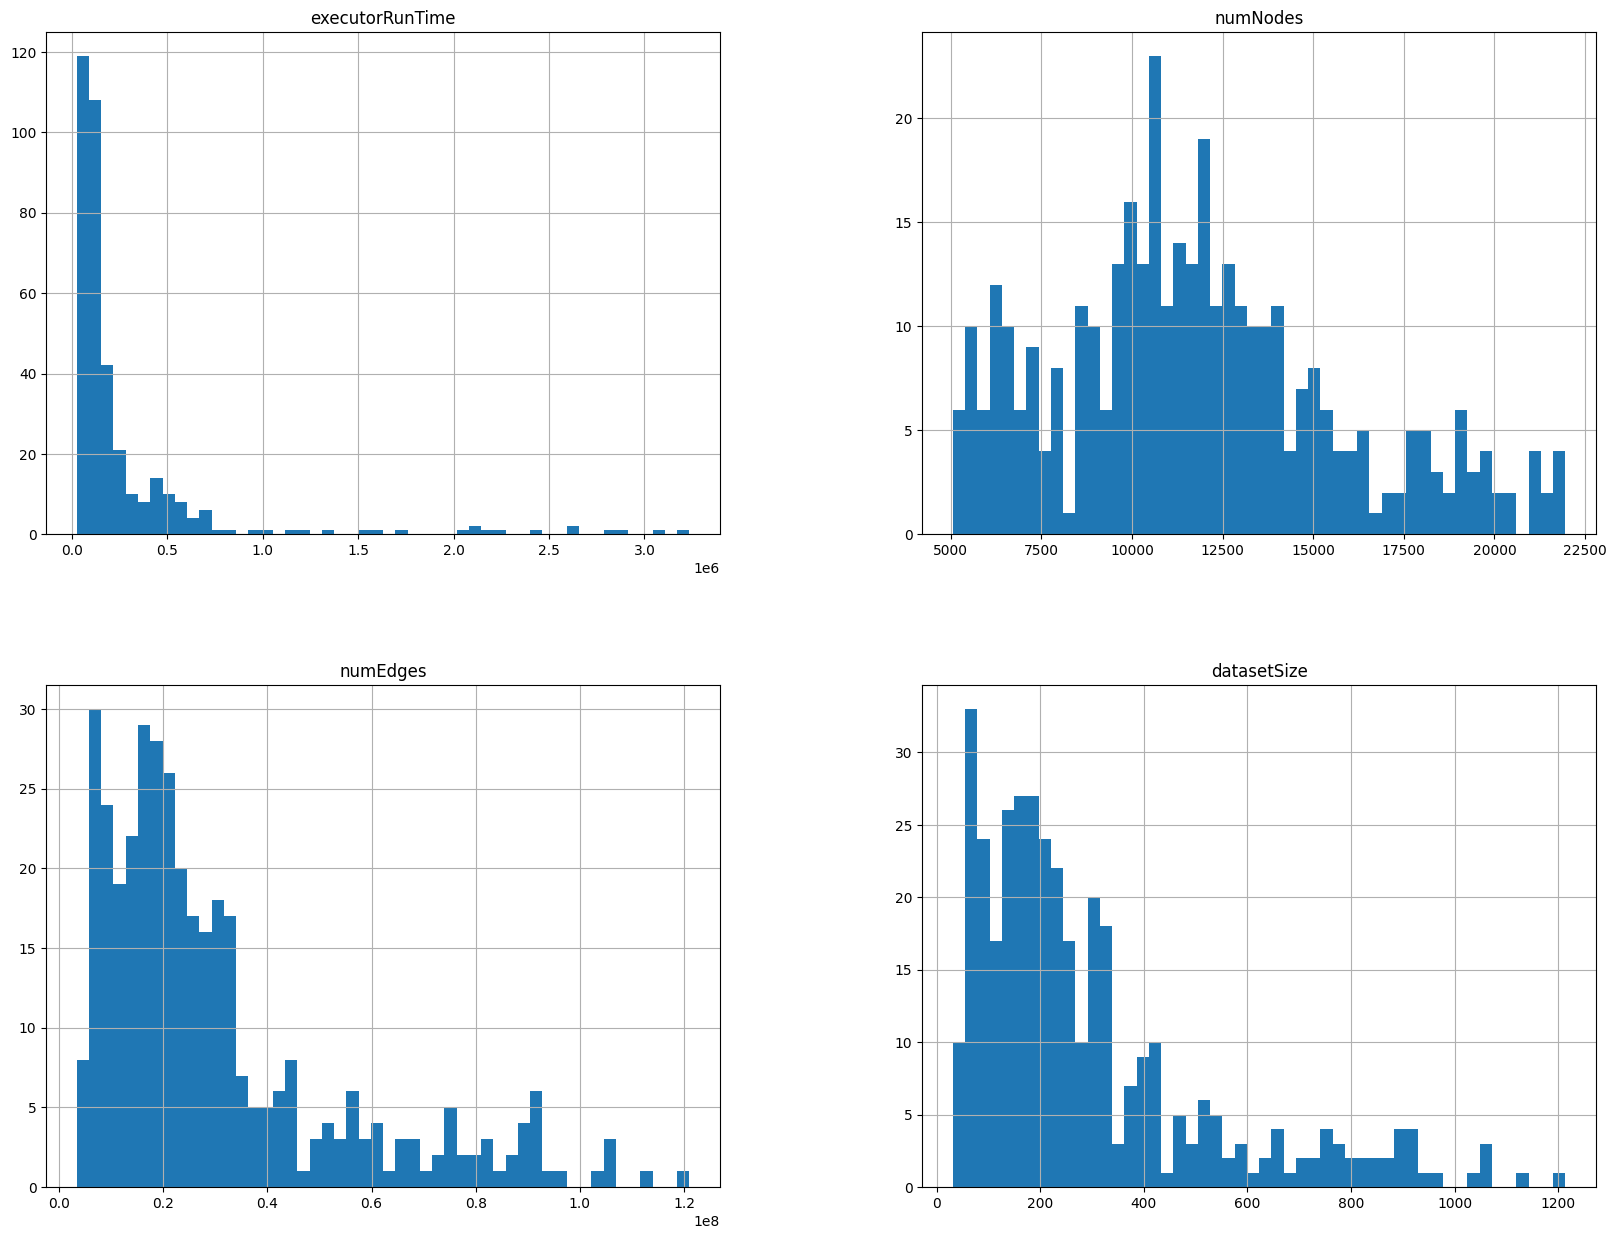

In [289]:
# Distributions of the data
df.hist(bins=50, figsize=(20,15))
plt.show()


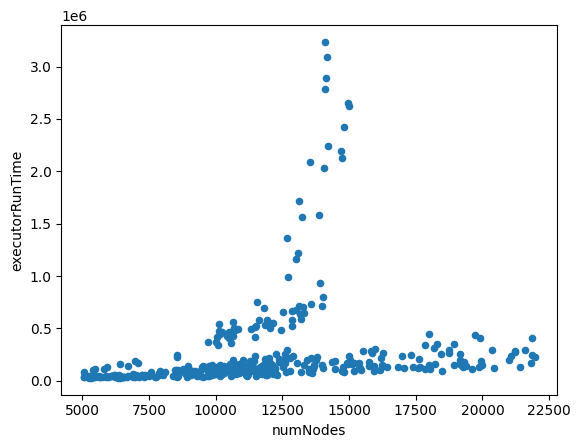

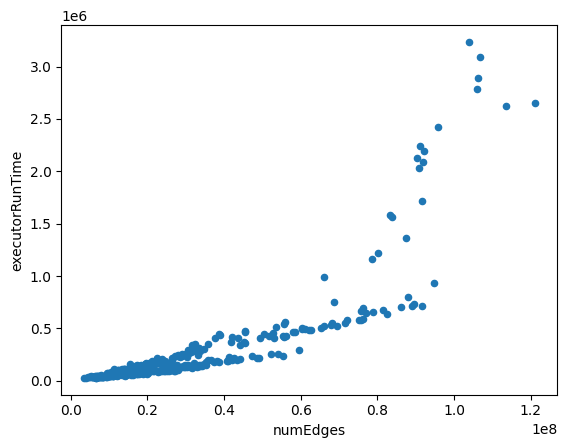

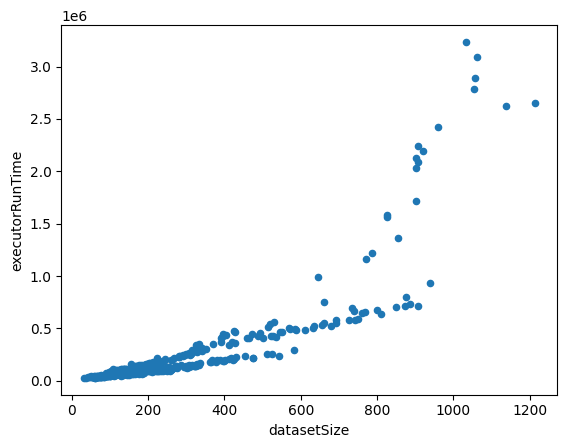

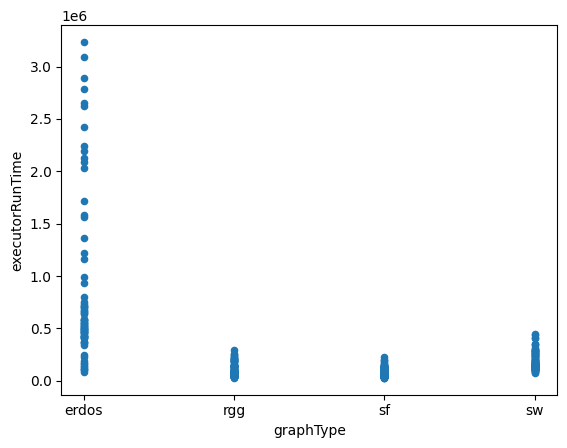

In [290]:
for feature in df.iloc[:,1:].columns:
    df.plot(kind='scatter', x=feature, y=label)

In [291]:
# Turn string column into categorical columns
def one_hot_encode(df, column):
    one_hot = pd.get_dummies(df[column]).astype(int) 
    df = df.drop(column, axis=1)
    df = df.join(one_hot)
    return df

df_encoded = one_hot_encode(df, 'graphType')

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   executorRunTime  372 non-null    int64  
 1   numNodes         372 non-null    int64  
 2   numEdges         372 non-null    int64  
 3   datasetSize      372 non-null    float64
 4   erdos            372 non-null    int64  
 5   rgg              372 non-null    int64  
 6   sf               372 non-null    int64  
 7   sw               372 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 23.4 KB


In [292]:
labels = df_encoded[[label]]
features = df_encoded.iloc[:,1:]

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [293]:
features

,numNodes,numEdges,datasetSize,erdos,rgg,sf,sw
0,12031,71630973,693.582353,1,0,0,0
1,10528,49278147,464.758146,1,0,0,0
2,14224,91211309,907.948590,1,0,0,0
3,12685,87428443,854.496320,1,0,0,0
4,12157,68122947,660.852936,1,0,0,0
...,...,...,...,...,...,...,...
367,10019,17974086,167.682317,0,0,0,1
368,10788,11370552,107.788972,0,0,0,1
369,12059,21489138,208.162624,0,0,0,1
370,18727,30525010,314.788679,0,0,0,1


In [294]:
# Normalize the data
def scale(df, mean, std):
    df = (df - mean) / std
    return df

def descale(df, mean, std):
    df = (df * std) + mean
    return df
X_train_numerics = X_train.iloc[:,:3]
x_train_mean = X_train_numerics.mean()
x_train_std = X_train_numerics.std()
X_train.iloc[:,:3] = scale(X_train.iloc[:,:3], x_train_mean, x_train_std)
X_test.iloc[:,:3] = scale(X_test.iloc[:,:3], x_train_mean, x_train_std)

y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = scale(y_train, y_train_mean, y_train_std)
y_test = scale(y_test, y_train_mean, y_train_std)


In [295]:
X_train

,numNodes,numEdges,datasetSize,erdos,rgg,sf,sw
192,-0.066225,-0.959958,-0.949467,0,0,1,0
75,-0.810716,0.161772,0.093723,1,0,0,0
84,-0.266433,0.110457,0.070601,0,1,0,0
360,1.030138,0.036138,0.083481,0,0,0,1
16,-0.404516,0.997179,0.893626,1,0,0,0
...,...,...,...,...,...,...,...
71,-1.686750,-0.796089,-0.813413,1,0,0,0
106,-1.272250,-0.660870,-0.682501,0,1,0,0
270,0.744414,-0.362797,-0.335730,0,0,1,0
348,-0.103953,-0.394956,-0.403462,0,0,0,1


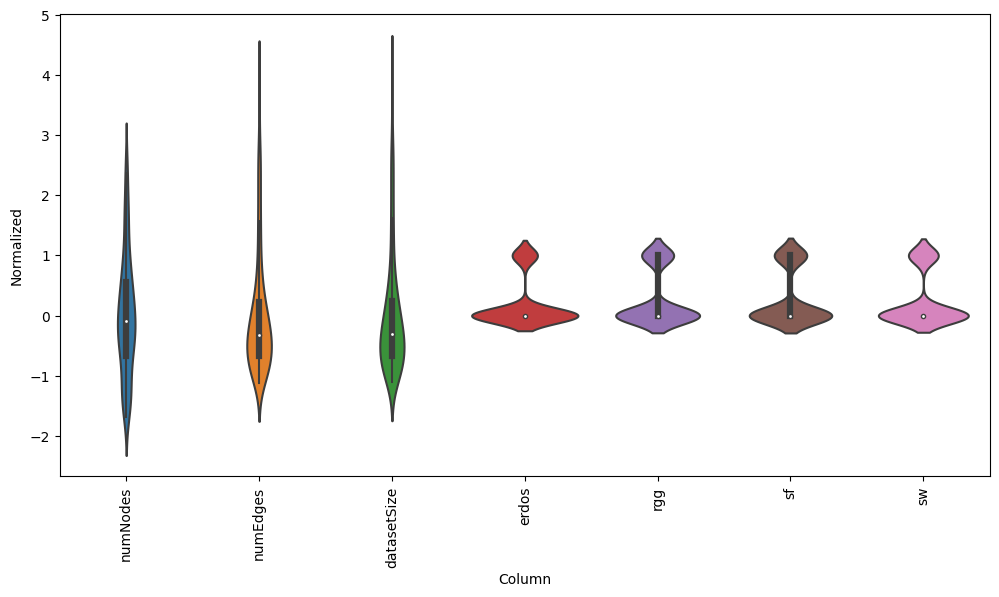

In [296]:
df_std = X_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(X_train.keys(), rotation=90)
plt.show()

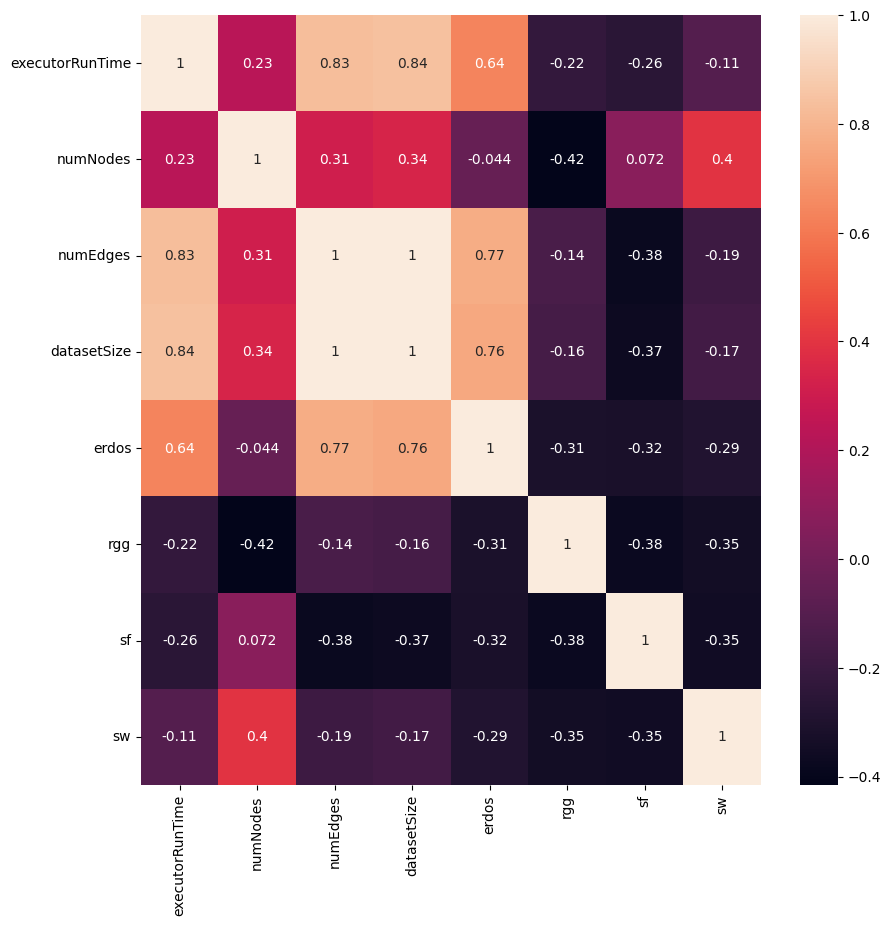

In [297]:
#correlation matrix for dataset big size

plt.figure(figsize=(10,10))
corrMatrix = df_encoded.corr()
sns.heatmap(corrMatrix, annot=True)

plt.show()



In [298]:
from sklearn.metrics import r2_score

fit_times = {}

mape_scores_cpu = {}
r2_scores_cpu = {}
prmse_scores_cpu = {}

def evaluate(y_true, y_pred, mean, std, name):
    y_pred = y_pred.reshape(len(y_true),1) 
    y_true = descale(y_true, mean, std)
    y_pred = descale(y_pred, mean, std)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    prmse = np.sqrt(np.mean((y_true - y_pred)**2))/(np.max(y_true) - np.min(y_true)) * 100

    return r2, mape, prmse


In [299]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

linear_model = LinearRegression()

start = time.time()
linear_model.fit(X_train, y_train)
stop = time.time()

fit_times['Linear Regression'] = stop - start

y_pred = linear_model.predict(X_test)

r2, mape, prmse = evaluate(y_test, y_pred[:,0], y_train_mean[0], y_train_std[0], 'Linear Regression')
mape_scores_cpu['Linear Regression'] = mape
r2_scores_cpu['Linear Regression'] = r2
prmse_scores_cpu['Linear Regression'] = prmse


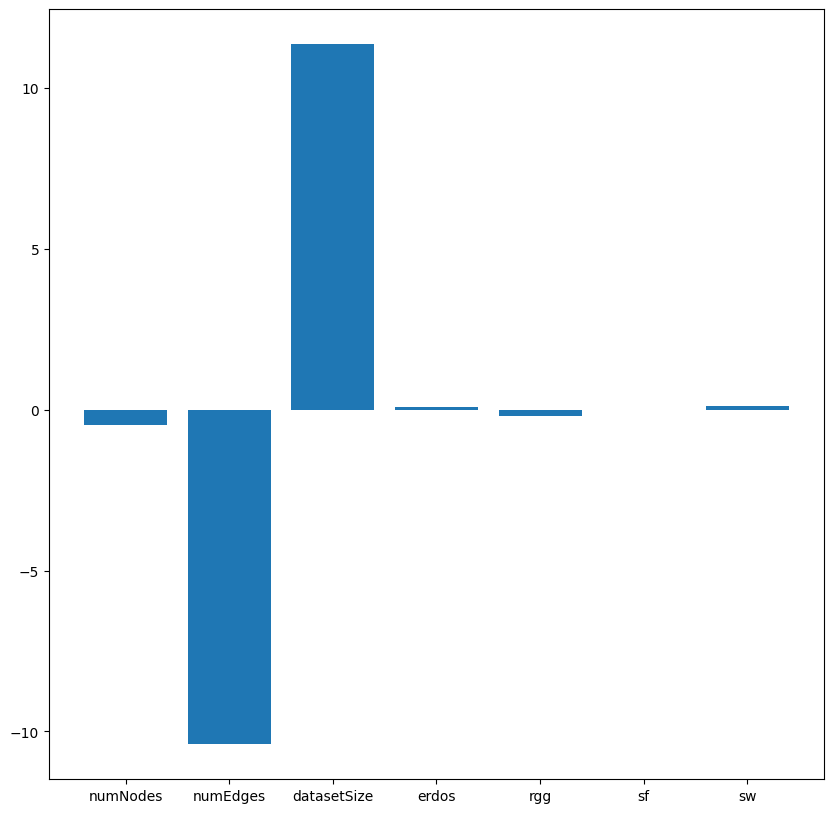

In [300]:
#plot coefficients
plt.figure(figsize=(10,10))
plt.bar(X_train.columns, linear_model.coef_[0])
plt.show()


In [301]:
#Forest
from sklearn.ensemble import RandomForestRegressor
#grid search
from sklearn.model_selection import GridSearchCV


param_grid = { 
    "n_estimators"      : [10,20,30,40,50,60,70,80,90,100],
    "max_features"      : ["sqrt", "log2"],
    "bootstrap": [True, False],
    }

forest_model = RandomForestRegressor()

grid_search = GridSearchCV(forest_model, param_grid, n_jobs=-1, cv=5)

start = time.time()
grid_search.fit(X_train, y_train.values.ravel())
stop = time.time()

fit_times['Random Forest'] = stop - start

y_pred = grid_search.predict(X_test)

r2, mape, prmse = evaluate(y_test, y_pred, y_train_mean[0], y_train_std[0], 'Random Forest')
mape_scores_cpu['Random Forest'] = mape
r2_scores_cpu['Random Forest'] = r2
prmse_scores_cpu['Random Forest'] = prmse

print(grid_search.best_params_)
print(f"mape: {mape}")
print(f"r2: {r2}")
print(f"prmse: {prmse}")

{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 20}
mape: 9.04675041744736
r2: 0.9483385559641728
prmse: 4.20421734249519


In [302]:
n = len(df_encoded)
train_df = df_encoded[:int(n*0.7)]
val_df = df_encoded[int(n*0.7):int(n*0.85)]
test_df = df_encoded[int(n*0.85):]

In [303]:
train_df

,executorRunTime,numNodes,numEdges,datasetSize,erdos,rgg,sf,sw
0,555882,12031,71630973,693.582353,1,0,0,0
1,409011,10528,49278147,464.758146,1,0,0,0
2,2241523,14224,91211309,907.948590,1,0,0,0
3,1359185,12685,87428443,854.496320,1,0,0,0
4,555233,12157,68122947,660.852936,1,0,0,0
...,...,...,...,...,...,...,...,...
255,96239,15952,18362786,186.055529,0,0,1,0
256,120560,14035,28112279,275.945859,0,0,1,0
257,117502,20440,18303054,190.736539,0,0,1,0
258,73726,11519,15610293,149.225561,0,0,1,0


In [304]:
train_mean = train_df.iloc[:,:4].mean()
train_std = train_df.iloc[:,:4].std()

train_df.iloc[:,:4] = (train_df.iloc[:,:4] - train_mean) / train_std
val_df.iloc[:,:4] = (val_df.iloc[:,:4] - train_mean) / train_std
test_df.iloc[:,:4] = (test_df.iloc[:,:4] - train_mean) / train_std

def df_to_dataset(df, shuffle=True, batch_size=32, label=label):
    df = df.copy()
    labels = df[[label]]
    features = df.iloc[:,1:]
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

def ds_to_numpy(ds):
    features = np.empty((0, 7))
    labels = np.empty((0, 1))

    for input, label in test_dataset:
        features = np.append(features, input.numpy(), axis=0)
        labels = np.append(labels, label.numpy(), axis=0)
    return features, labels

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

In [305]:
train_df

,executorRunTime,numNodes,numEdges,datasetSize,erdos,rgg,sf,sw
0,0.411870,0.428845,1.392436,1.364031,1,0,0,0
1,0.151322,-0.008061,0.575291,0.519056,1,0,0,0
2,3.402192,1.066326,2.108229,2.155618,1,0,0,0
3,1.836927,0.618955,1.969940,1.958235,1,0,0,0
4,0.410719,0.465472,1.264194,1.243172,1,0,0,0
...,...,...,...,...,...,...,...,...
255,-0.403535,1.568637,-0.554873,-0.510105,0,0,1,0
256,-0.360390,1.011386,-0.198464,-0.178168,0,0,1,0
257,-0.365814,2.873250,-0.557057,-0.492819,0,0,1,0
258,-0.443473,0.280012,-0.655495,-0.646106,0,0,1,0


In [309]:
#Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 1
num_features = len(X_train.columns)

train_dataset = df_to_dataset(train_df, batch_size=batch_size, label=label)
val_dataset = df_to_dataset(val_df, shuffle=False, batch_size=batch_size, label=label)
test_dataset = df_to_dataset(test_df, shuffle=False, batch_size=batch_size, label=label)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(7, activation='elu'),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')  
])

model.compile(optimizer='adam', loss='mean_absolute_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

start = time.time()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[early_stopping])
stop = time.time()

fit_times['Neural Network'] = stop - start

y_pred = model.predict(test_dataset)

x_test, y_test = ds_to_numpy(test_dataset)

r2, mape, prmse = evaluate(y_test, y_pred, train_mean[0], train_std[0], 'Neural Network')
mape_scores_cpu['Neural Network'] = mape
r2_scores_cpu['Neural Network'] = r2
prmse_scores_cpu['Neural Network'] = prmse

print(f"mape: {mape}")
print(f"r2: {r2}")
print(f"prmse: {prmse}")

Epoch 1/100


  1/260 [..............................] - ETA: 49s - loss: 0.0564

2023-09-11 15:13:45.602813: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [260,7]
	 [[{{node Placeholder/_0}}]]
2023-09-11 15:13:45.603041: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [260,1]
	 [[{{node Placeholder/_1}}]]


260/260 [==============================] - 0s 704us/step - loss: 0.2344 - val_loss: 0.0672
Epoch 2/100
260/260 [==============================] - 0s 501us/step - loss: 0.2172 - val_loss: 0.0787
Epoch 3/100
  1/260 [..............................] - ETA: 0s - loss: 0.1641

2023-09-11 15:13:45.917189: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,1]
	 [[{{node Placeholder/_1}}]]


260/260 [==============================] - 0s 511us/step - loss: 0.2037 - val_loss: 0.0538
Epoch 4/100
260/260 [==============================] - 0s 460us/step - loss: 0.2048 - val_loss: 0.0642
Epoch 5/100
260/260 [==============================] - 0s 454us/step - loss: 0.1942 - val_loss: 0.0755
Epoch 6/100
260/260 [==============================] - 0s 463us/step - loss: 0.1881 - val_loss: 0.0452
Epoch 7/100
260/260 [==============================] - 0s 469us/step - loss: 0.1844 - val_loss: 0.0669
Epoch 8/100
260/260 [==============================] - 0s 478us/step - loss: 0.1883 - val_loss: 0.0351
Epoch 9/100
260/260 [==============================] - 0s 490us/step - loss: 0.1758 - val_loss: 0.0531
Epoch 10/100
260/260 [==============================] - 0s 478us/step - loss: 0.1683 - val_loss: 0.0545
Epoch 11/100
260/260 [==============================] - 0s 463us/step - loss: 0.1645 - val_loss: 0.0466
Epoch 12/100
260/260 [==============================] - 0s 458us/step - loss: 0.152

2023-09-11 15:13:51.441869: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,1]
	 [[{{node Placeholder/_1}}]]


In [311]:
#save model
try:
    model = tf.keras.models.load_model(f'models/{dataset}Model.h5')
except:
    model.save(f'models/{dataset}Model.h5')

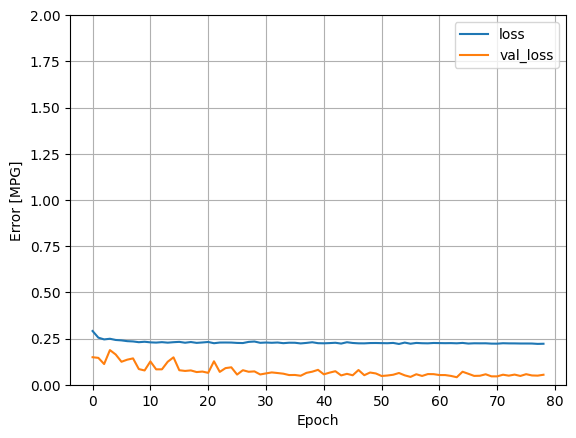

In [232]:
plot_loss(history)

In [315]:
mape_scores_cpu

{'Linear Regression': 74.42795673840168,
 'Random Forest': 9.04675041744736,
 'Neural Network': 6.318042318900146}

In [316]:
r2_scores_cpu

{'Linear Regression': 0.7861044221679652,
 'Random Forest': 0.9483385559641728,
 'Neural Network': 0.9292638731661531}

In [317]:
prmse_scores_cpu

{'Linear Regression': 8.55466075192957,
 'Random Forest': 4.20421734249519,
 'Neural Network': 6.352638677923901}

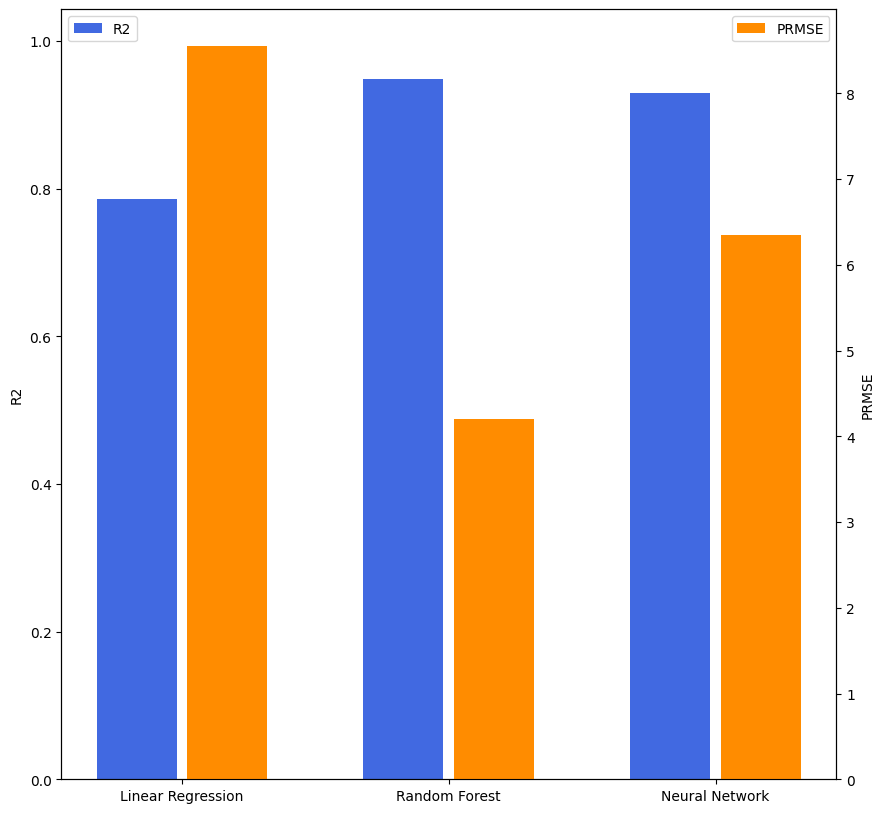

In [318]:
x = np.arange(len(r2_scores_cpu))
width = 0.3

r2 = r2_scores_cpu.values()
prmse = prmse_scores_cpu.values()


fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.set_ylabel('R2')
ax1.bar(x - 0.17, r2, width, label='R2', color='royalblue')
ax1.set_ylim([0, max((max(r2) * 1.1, 1))])
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('PRMSE')
ax2.bar(x + 0.17, prmse, width, label='PRMSE', color='darkorange')
ax2.legend(loc='upper right')
plt.xticks(ticks=x, labels=r2_scores_cpu.keys())
pass


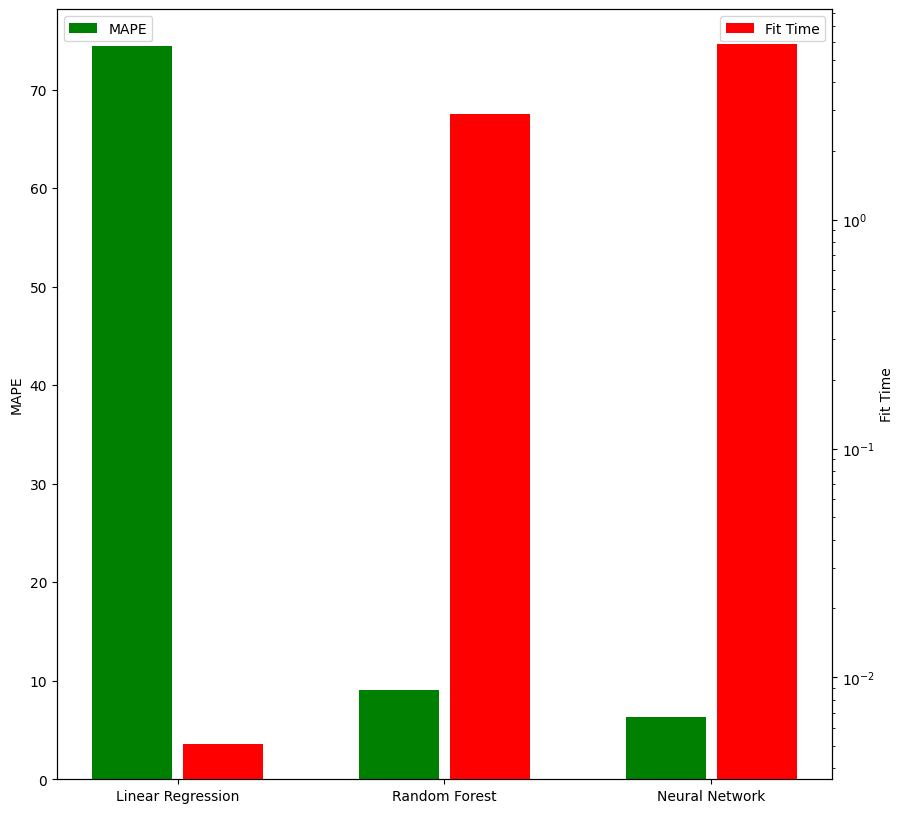

In [319]:
#mape and time plot

mape = mape_scores_cpu.values()
time = fit_times.values()

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.set_ylabel('MAPE')
ax1.bar(x - 0.17, mape, width, label='MAPE', color='g')

ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('Fit Time')
ax2.bar(x + 0.17, time, width, label='Fit Time', color='r')
ax2.set_yscale('log')
ax2.legend(loc='upper right')
plt.xticks(ticks=x, labels=mape_scores_cpu.keys())
pass


In [320]:
for key in fit_times.keys():
    #round in 3 decimals
    print(f"\item Fit Time: {fit_times[key]:.3f}s")
    print(f"\item MAPE: {mape_scores_cpu[key]:.3f}\\%")
    print(f"\item R2: {r2_scores_cpu[key]:.3f}")
    print(f"\item PRMSE: {prmse_scores_cpu[key]:.3f}\\%")

\item Fit Time: 0.005s
\item MAPE: 74.428\%
\item R2: 0.786
\item PRMSE: 8.555\%
\item Fit Time: 2.907s
\item MAPE: 9.047\%
\item R2: 0.948
\item PRMSE: 4.204\%
\item Fit Time: 5.840s
\item MAPE: 6.318\%
\item R2: 0.929
\item PRMSE: 6.353\%
